In this notebook I will: 
- determine the appropriate parameter step sizes for stable numerical derivatives. We want to get away with the smallest step sizes for $\log M_{\rm min}$ and $\sigma_{\log M}$ due to the halo mass limit of the standard simulations 
- confirm that the numerical derivatives are consistent between the high and standard resolutions. 
- compare the derivatives taken at the fiducial HOD (w/ standard resolution sims) to the derivatives taken at the $M_r < -22$ best-fit HOD (w/ higher resolution sims). If they're similar, that's better since that means we're closer to an observed sample

In [1]:
import os 
import scipy as sp 
import numpy as np 
# --- eMaNu --- 
from emanu import util as UT
from emanu import forwardmodel as FM
from emanu.hades import data as hadesData

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from matplotlib.ticker import StrMethodFormatter, NullFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.colors import LogNorm
from matplotlib.colors import SymLogNorm
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline 

In [3]:
theta_lbls = [r'$\log M_{\rm min}$', r'$\sigma_{\log M}$',r'$\log M_0$',r'$\alpha$',r'$\log M_1$']
hod_fid = np.array([14.22, 0.55, 14.00, 0.87, 14.69]) # fiducial HOD parameters (selected from hod_fiducial.ipynb)
hod_Mr22 = np.array([14.22, 0.77, 14.00, 0.87, 14.69]) # Zheng+(2007) Mr<-22

In [4]:
rbins = np.array([0.1, 0.15848932, 0.25118864, 0.39810717, 0.63095734, 1., 1.58489319, 2.51188643, 3.98107171, 6.30957344, 10., 15.84893192, 25.11886432]) 

def wp_model(tt, res='LR', rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating wp 
    '''
    return np.loadtxt(f_wp(tt, res=res, rsd=rsd, seed=seed), unpack=True, usecols=[0,1])

def pk_model(tt, res='LR', rsd=True, seed=None): 
    ''' wrapper for populating halos and calculating Pk 
    '''
    return np.loadtxt(f_pk(tt, res=res, rsd=rsd, seed=seed), unpack=True, usecols=[0,1])

def f_wp(tt, res='HR', rsd=True, seed=None):
    wp_dir = os.path.join('/Users/ChangHoon/data/emanu/hod', 'wp') 
    return os.path.join(wp_dir, 
            'wp.z07hod%.2f_%.2f_%.2f_%.2f_%.2f.%s.%i.%s.dat' % 
            (tt[0], tt[1], tt[2], tt[3], tt[4], ['rspace', 'zspace'][rsd], seed, res))

def f_pk(tt, res='HR', rsd=True, seed=None): 
    ''' return file name for wp given HOD parameters
    '''
    pk_dir = os.path.join('/Users/ChangHoon/data/emanu/hod', 'pk') 
    return os.path.join(pk_dir, 
            'pk.z07hod%.2f_%.2f_%.2f_%.2f_%.2f.%s.%i.%s.dat' % 
            (tt[0], tt[1], tt[2], tt[3], tt[4], ['rspace', 'zspace'][rsd], seed, res))

def dwpdtheta(tt, dtt, res='HR', rsd=True, log=True, nreal=1): 
    ''' calculate all dP(k)/dtheta derivatives numerically
    '''
    dwps = [] 
    for i in range(len(tt)): 
        _ttp = tt.copy() 
        _ttm = tt.copy() 
        _ttp[i] = tt[i] + dtt[i] 
        _ttm[i] = tt[i] - dtt[i] 
        wpp, wpm = [], [] 
        for ireal in range(nreal): 
            _, _wpp = wp_model(_ttp, res=res, rsd=rsd, seed=ireal)
            _r, _wpm = wp_model(_ttm, res=res, rsd=rsd, seed=ireal)
            wpp.append(_wpp)
            wpm.append(_wpm)
        wpp = np.average(np.array(wpp), axis=0)
        wpm = np.average(np.array(wpm), axis=0) 
        if log: dwp = 0.5*(np.log(wpp) - np.log(wpm))/dtt[i]
        else: dwp = 0.5*(wpp - wpm)/dtt[i]
        dwps.append(dwp) 
    return _r, dwps


def dpkdtheta(tt, dtt, res='HR', rsd=True, log=True, nreal=1): 
    ''' calculate all dP(k)/dtheta derivatives numerically
    '''
    dpks = [] 
    for i in range(len(tt)): 
        _ttp = tt.copy() 
        _ttm = tt.copy() 
        _ttp[i] = tt[i] + dtt[i] 
        _ttm[i] = tt[i] - dtt[i] 
        pkp, pkm = [], [] 
        for ireal in range(nreal): 
            k, _pkp = pk_model(_ttp, res=res, rsd=rsd, seed=ireal)
            k, _pkm = pk_model(_ttm, res=res, rsd=rsd, seed=ireal)
            pkp.append(_pkp)
            pkm.append(_pkm)
        pkp = np.average(np.array(pkp), axis=0)
        pkm = np.average(np.array(pkm), axis=0)
        if log: dpk = 0.5*(np.log(pkp) - np.log(pkm))/dtt[i] 
        else: dpk = 0.5*(pkp - pkm)/dtt[i]
        dpks.append(dpk) 
    return k, dpks

Lets calculate the derivatives using the higher resolution halo catalog to deterimine a *sensible* step size. Afterwards, I'll check that there's no significant difference with the lower resolution simulations.

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in divide


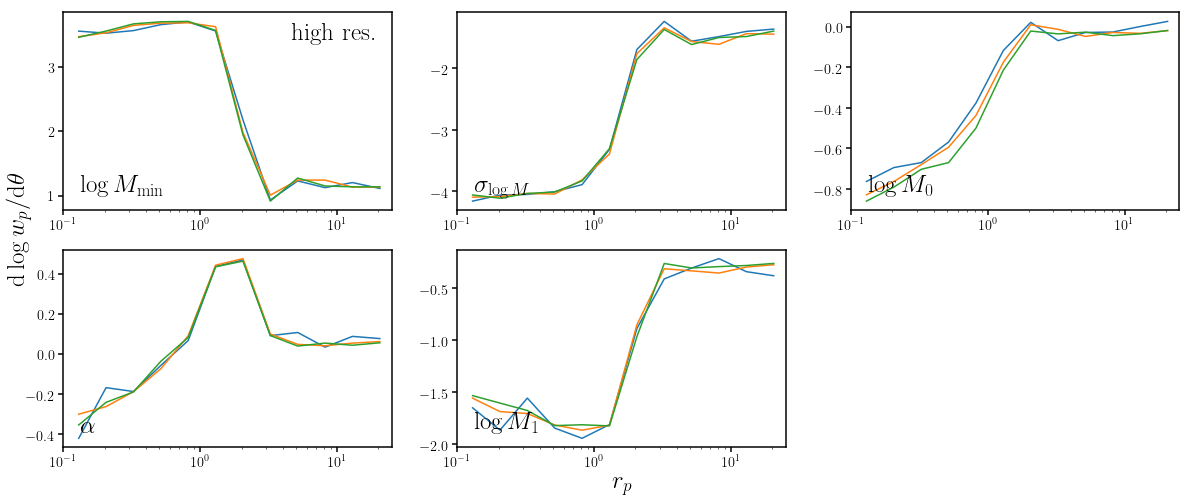

In [6]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    if i == 0: # Mmin 
        dtt = [0.05, 0.1, 0.15]
    elif i == 1: # sigma_logM
        dtt = [0.05, 0.1, 0.15]
    elif i == 2: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 3: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 4:
        dtt = [0.05, 0.1, 0.15]
    
    sub = fig.add_subplot(2,3,i+1)
    for _dtt in dtt: 
        _dtheta = np.zeros(5)
        _dtheta[i] = _dtt
        _, _dlogwps_hr = dwpdtheta(hod_fid, _dtheta, res='HR', rsd=True, log=True, nreal=10)

        sub.plot(0.5*(rbins[1:] + rbins[:-1]), _dlogwps_hr[i])
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide


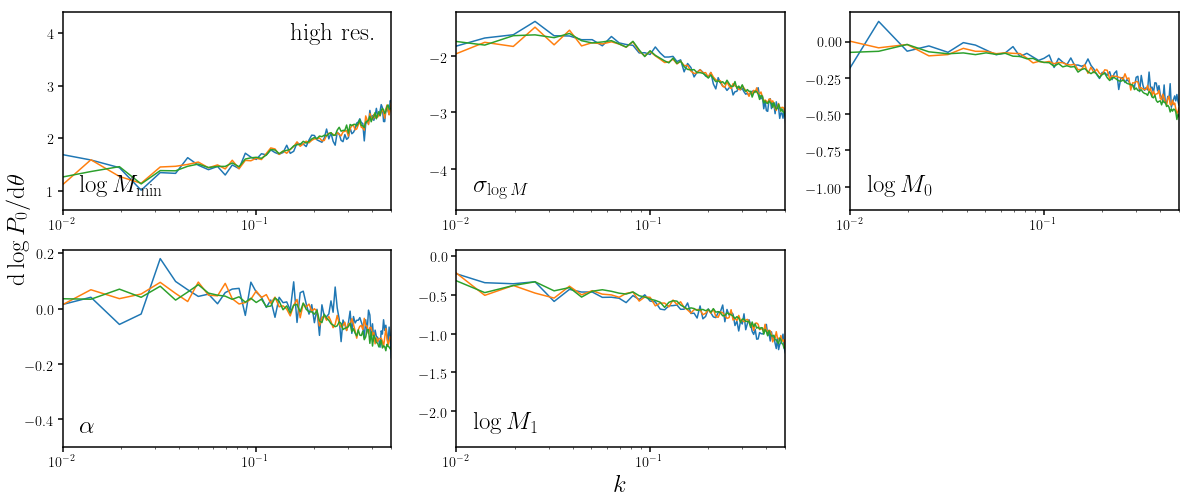

In [7]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    if i == 0: # Mmin 
        dtt = [0.05, 0.1, 0.15]
    elif i == 1: # sigma_logM
        dtt = [0.05, 0.1, 0.15]
    elif i == 2: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 3: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 4:
        dtt = [0.05, 0.1, 0.15]
    
    sub = fig.add_subplot(2,3,i+1)
    for _dtt in dtt: 
        _dtheta = np.zeros(5)
        _dtheta[i] = _dtt
        k, _dlogpks_hr = dpkdtheta(hod_fid, _dtheta, res='HR', rsd=True, log=True, nreal=10)
        sub.plot(k, _dlogpks_hr[i])
        
    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

Based on the step size comparisons, it seems that for $M_{\rm min}$ and $\sigma_{\log M}$ we can get away with step sizes of 0.1. By eye, it seems that the following step sizes are sensible: 
$$\{\Delta M_{\rm min}, \Delta \sigma_{\log M}, \Delta \log M_0, \Delta \alpha, \Delta \log M_1\} = \{0.1, 0.1, 0.2, 0.3, 0.15\}$$

Next, lets see how similar the derivatives are to the derivatives at the $M_r < -22$ HOD best-fit

In [8]:
# get the derivative of wp and pk for the Mr=-22 sample for reference
_, dlogwps_Mr22 = dwpdtheta(hod_Mr22, np.array([0.1, 0.1, 0.2, 0.2, 0.15]), res='HR', rsd=True, log=True, nreal=10)
_, dlogpks_Mr22 = dpkdtheta(hod_Mr22, np.array([0.1, 0.1, 0.2, 0.2, 0.15]), res='HR', rsd=True, log=True, nreal=10)

/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in divide
/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in divide


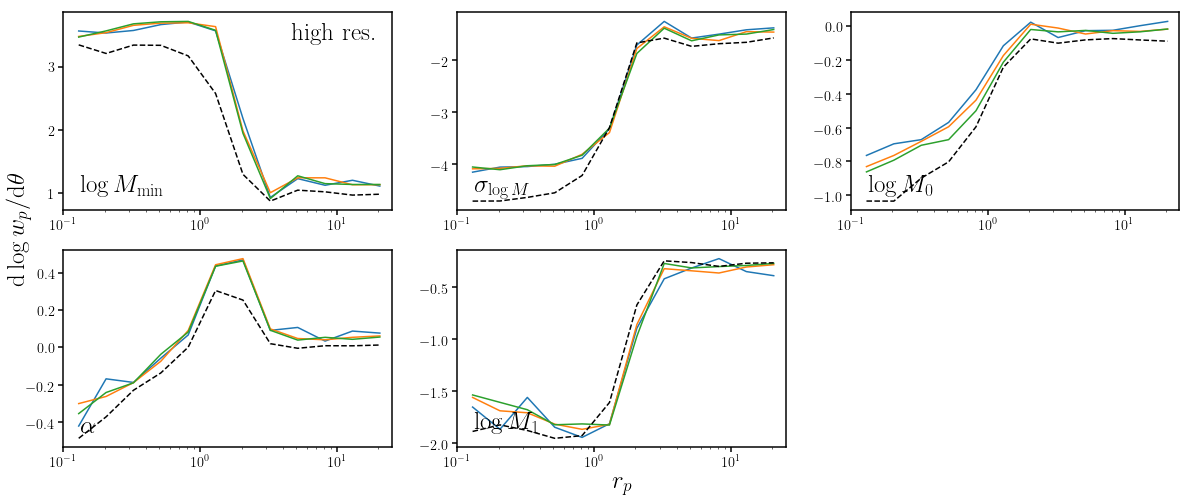

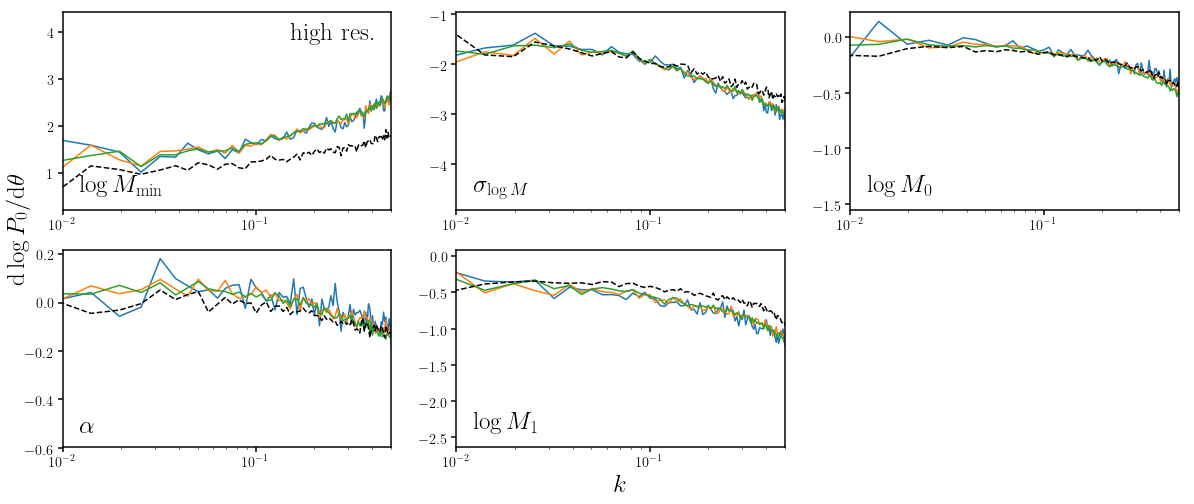

In [9]:
fig = plt.figure(figsize=(20, 8))
for i in range(5):
    if i == 0: # Mmin 
        dtt = [0.05, 0.1, 0.15]
    elif i == 1: # sigma_logM
        dtt = [0.05, 0.1, 0.15]
    elif i == 2: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 3: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 4:
        dtt = [0.05, 0.1, 0.15]
    
    sub = fig.add_subplot(2,3,i+1)
    for _dtt in dtt: 
        _dtheta = np.zeros(5)
        _dtheta[i] = _dtt
        _, _dlogwps_hr = dwpdtheta(hod_fid, _dtheta, res='HR', rsd=True, log=True, nreal=10)

        sub.plot(0.5*(rbins[1:] + rbins[:-1]), _dlogwps_hr[i])

    sub.plot(0.5*(rbins[1:] + rbins[:-1]), dlogwps_Mr22[i], c='k', ls='--')
    
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    if i == 0: # Mmin 
        dtt = [0.05, 0.1, 0.15]
    elif i == 1: # sigma_logM
        dtt = [0.05, 0.1, 0.15]
    elif i == 2: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 3: 
        dtt = [0.1, 0.2, 0.3]
    elif i == 4:
        dtt = [0.05, 0.1, 0.15]
    
    sub = fig.add_subplot(2,3,i+1)
    for _dtt in dtt: 
        _dtheta = np.zeros(5)
        _dtheta[i] = _dtt
        k, _dlogpks_hr = dpkdtheta(hod_fid, _dtheta, res='HR', rsd=True, log=True, nreal=10)

        sub.plot(k, _dlogpks_hr[i])

    sub.plot(k, dlogpks_Mr22[i], c='k', ls='--')
    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

Unfortunately the derivatives are not too similar to the derivatives at the $M_r < -22$ HOD. However, it's a trade-off between number density and having a realistic sample. Now lets compare the derivatives calculated from the high resolution to the derivative from the low resolution sims. 

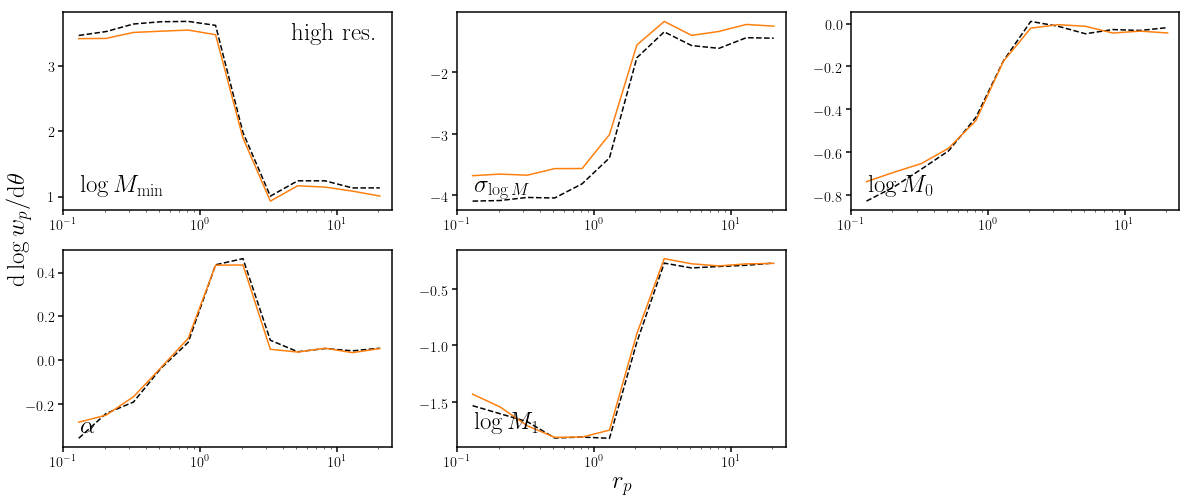

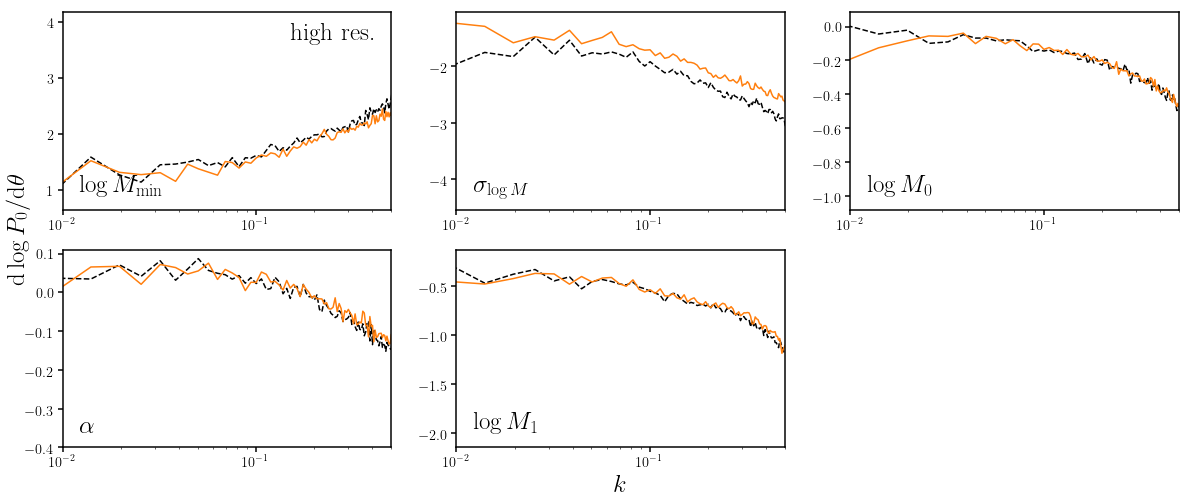

In [11]:
# step sizes that we decided on above
dthetas = [0.1, 0.1, 0.2, 0.3, 0.15]

_, _dlogwps_hr = dwpdtheta(hod_fid, dthetas, res='HR', rsd=True, log=True, nreal=10)
_, _dlogwps_lr = dwpdtheta(hod_fid, dthetas, res='LR', rsd=True, log=True, nreal=10)

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), _dlogwps_hr[i], c='k', ls='--')
    sub.plot(0.5*(rbins[1:] + rbins[:-1]), _dlogwps_lr[i], c='C1')
    sub.set_xscale('log') 
    sub.set_xlim(1e-1, 25) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$r_p$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log w_p/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)

_, _dlogpks_hr = dpkdtheta(hod_fid, dthetas, res='HR', rsd=True, log=True, nreal=10)
k, _dlogpks_lr = dpkdtheta(hod_fid, dthetas, res='LR', rsd=True, log=True, nreal=10)

fig = plt.figure(figsize=(20, 8))
for i in range(5):
    sub = fig.add_subplot(2,3,i+1)
    sub.plot(k, _dlogpks_hr[i], c='k', ls='--')
    sub.plot(k, _dlogpks_lr[i], c='C1')        
    sub.set_xscale('log') 
    sub.set_xlim(1e-2, 0.5) 
    if i == 0: sub.text(0.95, 0.95, 'high res.', ha='right', va='top', transform=sub.transAxes, fontsize=25)
    sub.text(0.05, 0.05, theta_lbls[i], ha='left', va='bottom', transform=sub.transAxes, fontsize=25)
bkgd = fig.add_subplot(111, frameon=False)
bkgd.set_xlabel('$k$', fontsize=25) 
bkgd.set_ylabel(r'${\rm d} \log P_0/{\rm d} \theta$', fontsize=25) 
bkgd.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)